In [3]:
# Set the process name to be human readable in htop
import setproctitle
setproctitle.setproctitle("Calculate_Drug_Interfaces")

import requests
import pandas as pd
pd.options.display.max_columns = 999

import numpy as np
import helper as my

import glob
import os
import sys

from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook

tqdm.pandas(tqdm_notebook)
tqdm_notebook.pandas()


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from mjm_tools import zip_res_range, unzip_res_range

from collections import defaultdict
import subprocess as sp

# Paramaters for file locations

In [4]:
# Base directory for whole project
base_dir = "/home/sdw95/3D_SARS2"

# Calculate Ligand Interface Residues

In [5]:
drug_pairs = pd.read_csv("{0}/Data/Krogan_Drug_Candidates.txt".format(base_dir), sep="\t")

In [6]:
summary = []
pbar = tqdm_notebook(total=len(glob.glob("{0}/Data/Docked_Ligands/ranked_poses/*".format(base_dir))))
for drug, uni in tqdm_notebook(drug_pairs[~pd.isnull(drug_pairs["Human ID"])][["Compound Name", "Human ID"]].values):
    # Parse Inputs
    drug_orig = drug
    drug = drug.replace("-", "_").replace(" ", "_").split("(")[0]
    drug_f = glob.glob("{0}/Data/Ligands/{1}*".format(base_dir, drug))[0]
    
    try:
        uni_f = glob.glob("{0}/Data/Undocked_Structures/{1}*".format(base_dir, uni))[0]
    except IndexError:
        continue
    
    # Load all ranked docking poses
    outs = glob.glob("{0}/Data/Docked_Ligands/ranked_poses/{1}_{2}_*.pdb".format(base_dir, uni, drug))
    
    for f in outs:
        rank = int(f.split("_")[-1].split(".")[0])
        #print drug, uni, rank
        #continue
        if(not rank <= 10):
            continue
        score = float(open(f, "r").readlines()[1].split()[-1])
        ires = sp.check_output("python irescalc_ligand.py {0} {1}".format(uni_f, f), shell=True).strip()
        
        summary.append([uni, drug_orig, rank, score, ires])
        pbar.update()
summary = pd.DataFrame(summary, columns=["Human_Protein", "Compound_Name", "Rank", "Score", "Ires"])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/sdw95/.conda/envs/jp/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records



KeyboardInterrupt



In [ ]:
# Sort Summary By Drug Target Pair / Rank
summary = summary.sort_values(["Human_Protein", "Compound_Name", "Rank"])

In [ ]:
# Save Summary
summary.to_csv("{0}/Data/Drug_Docking_Ires_Summary.txt".format(base_dir), sep="\t", index=None)

In [8]:
summary = pd.read_csv("{0}/Data/Drug_Docking_Ires_Summary.txt".format(base_dir), sep="\t")

# Calculate Enrichment For Protein / Ligand IRES Overlap

In [9]:
# Read in Protein Interfaces (from docked results)
p_ires = pd.read_csv("{0}/Data/Interface_Summary.txt".format(base_dir), sep="\t")
p_ires = p_ires[p_ires["Source"] == "Docking"]

# Read in Ligand Interfaces
l_ires = pd.read_csv("{0}/Data/Drug_Docking_Ires_Summary.txt".format(base_dir), sep="\t")

In [10]:
# Merge the data (use left join to retain all ligand docks performed)
merged = l_ires.join(p_ires[["P1", "P2", "Source", "P2_Ires"]].set_index("P2"), on="Human_Protein", how="left")

In [11]:
# Read in Protein --> Sequence Map
uni2seq = pd.read_csv("{0}/Data/Proteins.txt".format(base_dir), sep="\t").set_index("ID")["Sequence"].to_dict()

In [12]:
# Calculate Binding Site Similarity and Recall
# Recall is the fraction of docked PPI interfaces
# that also appear in the docked drug binding site
def do(x):
    iresA, iresB = x
    if(pd.isnull(iresA)):
        iresA = set()
    else:
        iresA = set([int(x)-1 for x in iresA.split(",")])
    if(pd.isnull(iresB)):
        iresB = set()
    else:
        iresB = set([int(x)-1 for x in iresB.split(",")])
    
    return len(iresA.intersection(iresB)) / float(len(iresA.union(iresB))), len(iresA.intersection(iresB)) / float(len(iresA))
# FUNCTION END
tmp = merged[["Ires", "P2_Ires"]].apply(do, axis=1)

merged["Jaccard"] = [x[0] for x in tmp]
merged["Ligand Recall"] = [x[1] for x in tmp]

In [13]:
# Construct Coverage Masks for all of the
# human structures used in the docking
uni2coverage_mask = dict()
for uni in uni2seq:
    uni2coverage_mask[uni] = np.zeros(len(uni2seq[uni]))
    try:
        uni_f = glob.glob("{0}/Data/Undocked_Structures/{1}_*".format(base_dir, uni))[0]
    except IndexError:
        continue
    
    pdb_df = my.pdb2df(uni_f)
    resis = list(pdb_df["Residue ID"].unique() - 1)
    resis = [x for x in resis if x >= 0]
    
    uni2coverage_mask[uni][resis] = 1

/home/sdw95/bin/helper.py:3782: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.header = header
/home/sdw95/bin/helper.py:3783: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.tailer = tailer


In [32]:
# Calculate Log Odds Enrichment for Overlap between
# Drug / Protein Interfaces
uni2piresmask = dict()
uni2liresmask = dict()
def do(x):
    uni, iresA, iresB, rank = x
    mask1 = np.zeros(len(uni2seq[uni]))
    mask2 = np.zeros(len(uni2seq[uni]))
    
    if(pd.isnull(iresA)):
        iresA = set()
    else:
        iresA = set([int(x)-1 for x in iresA.split(",")])
    if(pd.isnull(iresB)):
        iresB = set()
    else:
        iresB = set([int(x)-1 for x in iresB.split(",")])
    
    mask1[sorted(iresA)] = 1
    mask2[sorted(iresB)] = 1
    
    coverage_mask = uni2coverage_mask[uni] == 1
    
    #print mask1[coverage_mask]
    #print type(mask1[coverage_mask])
    #print set(mask1[coverage_mask])
    #print set(mask2[coverage_mask])
    #1/0
    
    #OR, up, low, p = my.odds_ratio(mask1[coverage_mask], mask2[coverage_mask], verbose=True, expose_label="Protein", case_label="Drug")
    #OR, up, low, p = my.odds_ratio(mask1[coverage_mask], mask2[coverage_mask], two_sided=False, error="CI")
    OR, up, low, p = my.odds_ratio(mask1[coverage_mask], mask2[coverage_mask], two_sided=False, error="SE")
    OR, up, low = np.log2([OR, up, low])
    
    if(uni == "P27448" and rank == 1):
        OR, up, low, p = my.odds_ratio(mask1[coverage_mask], mask2[coverage_mask], two_sided=False, error="SE", verbose=True)
        print OR
    
    if(rank == 1 and sum(mask2) != 0):
        if(not uni in uni2piresmask.keys()):
            uni2piresmask[uni] = mask1[coverage_mask] == 1
            uni2liresmask[uni] = mask2[coverage_mask] == 1
        else:
            print "HERE"
            uni2piresmask[uni] = uni2piresmask[uni] | (mask1[coverage_mask] == 1)
            uni2liresmask[uni] = uni2liresmask[uni] | (mask2[coverage_mask] == 1)
    elif(rank == 1):
        print uni
    return OR, up, low, p
# FUNCTION END
tmp = merged[["Human_Protein", "Ires", "P2_Ires", "Rank"]].progress_apply(do, axis=1)
merged["Log2 Odds Ratio"] = [x[0] for x in tmp]
merged["Lower CI"] = [x[2] for x in tmp]
merged["Upper CI"] = [x[1] for x in tmp]
merged["p-value"] = [x[3] for x in tmp]

O60573
HERE
HERE
HERE
HERE
             Case  Non-Case
Exposed       0.0      10.0
Non-Exposed  40.0     263.0
nan
             Case  Non-Case
Exposed      12.0       3.0
Non-Exposed  28.0     270.0
38.5714285714
HERE
P78406
Q15056
Q15904
Q5BJF2
Q5BJF2
HERE
Q99567
Q99720
Q99720
Q99720
Q99720
Q99720
Q99720
Q9Y6M9


In [68]:
# Overall Enrichment Across all Genes
pires_mask = np.concatenate([uni2piresmask[uni] for uni in uni2piresmask.keys()])
lires_mask = np.concatenate([uni2liresmask[uni] for uni in uni2piresmask.keys()])

OR, up, low, p = my.odds_ratio(pires_mask, lires_mask, two_sided=False, error="SE")
OR, up, low = np.log2([OR, up, low])
    
print OR, up, low, p

1.38365614924 1.65715213881 1.11016015966 2.10569134462e-07


In [2]:
2**1.383

2.6081014705171204

Text(0,0.5,'Log2(Odds Ratio)')

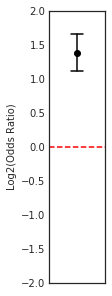

In [69]:
sns.set_style("white")
plt.figure(figsize=(1, 5))
plt.plot([0, 0], [up, low], color="k")
plt.plot([-0.1, 0.1], [up, up], color="k")
plt.plot([-0.1, 0.1], [low, low], color="k")
plt.scatter([0], [OR], color="k")
plt.ylim(-2, 2)
plt.plot([-0.5, 0.5], [0, 0], color="r", linestyle="--")
plt.xlim(-0.5, 0.5)
plt.xticks([0], [""])
plt.ylabel("Log2(Odds Ratio)")
#plt.savefig("Figures/Figure_5/Fig_5b_Overall_Enrichment.svg")

In [70]:
# Check for cases with perfect overlap at the interface
merged[(pd.isnull(merged["Log2 Odds Ratio"]))*(merged["Ligand Recall"] != 0)]

,Human_Protein,Compound_Name,Rank,Score,Ires,P1,Source,P2_Ires,Jaccard,Ligand Recall,Log2 Odds Ratio,Lower CI,Upper CI,p-value
16,P06280,Migalastat,7,-5.088696,"99,100,139,149,151",COVID19nsp14,Docking,"47,49,51,52,53,54,55,58,59,62,98,99,100,101,10...",0.096154,1.0,NaN,NaN,NaN,NaN
93,P21964,Entacapone,4,-6.258568,"88,90,191,193,194,223,224",COVID19nsp7,Docking,"55,56,58,84,85,86,87,88,90,191,193,194,223,224...",0.411765,1.0,NaN,NaN,NaN,NaN


In [71]:
# Reformat / Save
to_save = merged.copy()
to_save.columns = ["Human_Protein", "Compound_Name", "Docking_Rank", "Score", "Drug_Ires", "Viral_Interactor", "Source", "Protein_Ires", "Jaccard_Similarity", "Drug_Ires_Coverage", "Log2OR", "LowerCI", "UpperCI", "p-value"]
to_save = to_save[["Human_Protein", "Compound_Name", "Viral_Interactor", "Docking_Rank", "Score", "Drug_Ires", "Protein_Ires", "Source", "Jaccard_Similarity", "Drug_Ires_Coverage", "Log2OR", "LowerCI", "UpperCI", "p-value"]]

to_save.to_csv("{0}/Data/Drug_Interface_Enrichmet.txt".format(base_dir), sep="\t", index=None)

In [35]:
a = pd.read_csv("{0}/Data/Drug_Interface_Enrichmet.txt".format(base_dir), sep="\t")
a[a["Docking_Rank"] == 1]

,Human_Protein,Compound_Name,Viral_Interactor,Docking_Rank,Score,Drug_Ires,Protein_Ires,Source,Jaccard_Similarity,Drug_Ires_Coverage,Log2OR,LowerCI,UpperCI,p-value
0,O60573,Zotatifin (eFT226),NaN,1,-8.932130,"67,68,69,70,71,73,78,110,124,125,134,138,172,2...",NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
10,P06280,Migalastat,COVID19nsp14,1,-5.642324,"38,39,85,87,321","47,49,51,52,53,54,55,58,59,62,98,99,100,101,10...",Docking,0.000000,0.000000,NaN,NaN,NaN,NaN
20,P12268,Merimepodib,COVID19nsp14,1,-7.910938,"70,71,93,94,95,251,255,274,275,276,325,326,327...","36,37,38,39,40,41,42,45,238,242,371,392,394,39...",Docking,0.000000,0.000000,NaN,NaN,NaN,NaN
30,P12268,Mycophenolic acid,COVID19nsp14,1,-7.458368,"70,274,275,276,325,326,327,365,366,387,388","36,37,38,39,40,41,42,45,238,242,371,392,394,39...",Docking,0.000000,0.000000,NaN,NaN,NaN,NaN
40,P12268,Ribavirin,COVID19nsp14,1,-6.812905,"52,54,355,358,380,382,477,484","36,37,38,39,40,41,42,45,238,242,371,392,394,39...",Docking,0.000000,0.000000,NaN,NaN,NaN,NaN
50,P12268,Sanglifehrin A,COVID19nsp14,1,-11.206060,"52,57,58,60,62,236,238,239,240,241,242,243,264...","36,37,38,39,40,41,42,45,238,242,371,392,394,39...",Docking,0.036364,0.100000,-0.333424,-2.153281,1.486434,3.815698e-01
60,P17612,H-89,COVID19nsp13,1,-9.018489,"51,52,53,54,56,58,85,122,128,169,171,184,185,1...","48,52,53,54,56,79,82,83,130,131,134,135,136,13...",Docking,0.135593,0.500000,2.639824,1.390913,3.888736,2.537864e-04
70,P19784,Silmitasertib,COVID19N,1,-10.969420,"46,47,48,49,51,52,54,67,115,159,161,176","47,48,49,50,51,121,123,124,127,159,161,176,179...",Docking,0.194444,0.583333,4.119633,2.641715,5.597550,2.270367e-06
80,P19784,TMCB,COVID19N,1,-7.318310,"46,47,48,49,52,54,67,115,116,119,159,161,176","47,48,49,50,51,121,123,124,127,159,161,176,179...",Docking,0.157895,0.461538,3.343205,1.933497,4.752912,4.792419e-05
90,P21964,Entacapone,COVID19nsp7,1,-7.196985,"73,77,81,84,94,95,247,250,251,252","55,56,58,84,85,86,87,88,90,191,193,194,223,224...",Docking,0.125000,0.300000,2.524842,0.760267,4.289416,9.297844e-03


# Plotting Code (Should probably be relocated)

Text(0,0.5,'Ligand Recall')

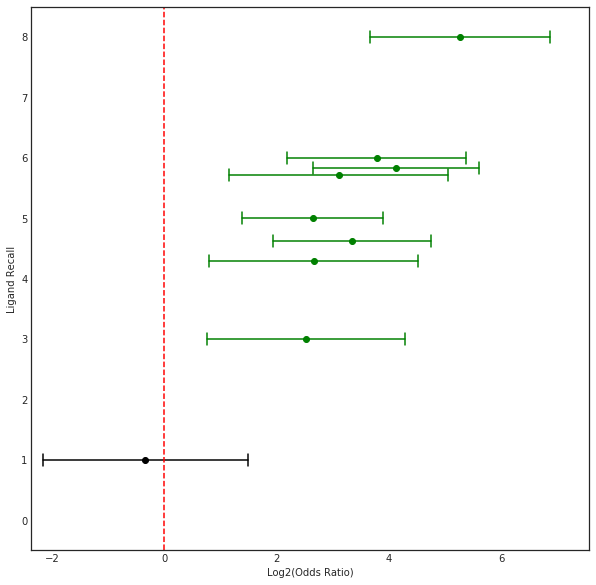

In [72]:
plt.figure(figsize=(10, 10))

i = 0
labels = []
s_min = 0.5
s_max = 0.5
merged["No Overlap"] = pd.isnull(merged["Log2 Odds Ratio"]) & (~pd.isnull(merged["P2_Ires"]))
for p1, p2, OR, up, low, p, p2ires, score in merged[merged["Rank"] == 1].sort_values(["No Overlap", "Log2 Odds Ratio"], ascending=[False, True])[["Human_Protein", "Compound_Name", "Log2 Odds Ratio", "Lower CI", "Upper CI", "p-value", "P2_Ires", "Ligand Recall"]].values:
    score = score*10
    if(not pd.isnull(p2ires) and pd.isnull(OR)):
        OR = -5
        up = -5
        low = -5
        p = 0.06
    if(pd.isnull(OR)):
        continue
    color = "k"
    if(p <= 0.05):
        color = "g"
    plt.plot([up, low], [score, score], color=color)
    plt.plot([up, up], [score-0.1, score+0.1], color=color)
    plt.plot([low, low], [score-0.1, score+0.1], color=color)
    plt.scatter([OR], [score], color=color)
    labels.append("_".join([p1, p2]).replace("COVID19", ""))
    i += 1
    s_min = min([s_min, score])
    s_max = max([s_max, score])
merged = merged.drop("No Overlap", axis=1)
plt.plot([0, 0], [s_min-0.5, s_max+0.5], color="r", linestyle="--")    
plt.xlim(merged[merged["Rank"] == 1]["Lower CI"].min()*1.1, merged[merged["Rank"] == 1]["Upper CI"].max()*1.1)
plt.ylim(s_min-0.5, s_max+0.5)
#plt.xticks(range(i), labels, rotation=90)
plt.xlabel("Log2(Odds Ratio)")
plt.ylabel("Ligand Recall")

Text(5.5,-3,'No Binding Site Overlap')

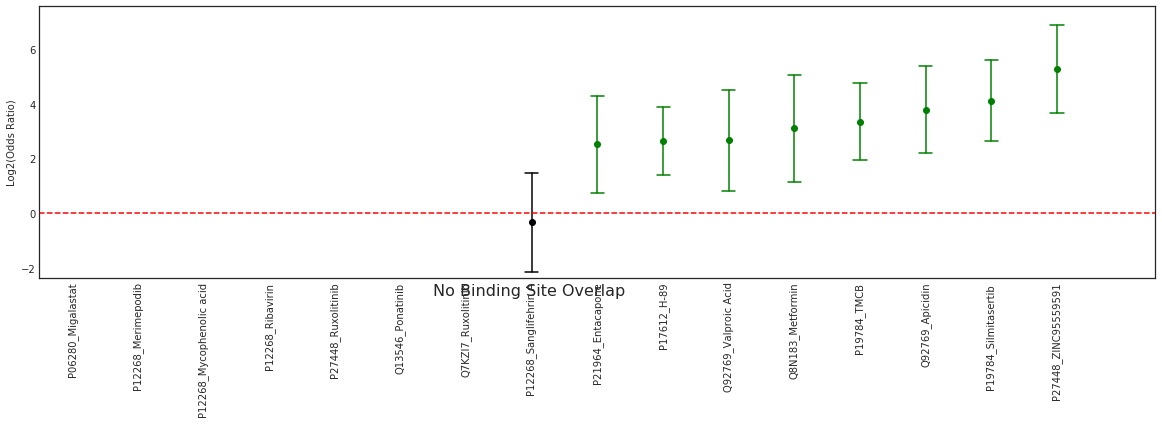

In [73]:
plt.figure(figsize=(20, 5))

i = 0
labels = []
merged["No Overlap"] = pd.isnull(merged["Log2 Odds Ratio"]) & (~pd.isnull(merged["P2_Ires"]))
for p1, p2, OR, up, low, p, p2ires in merged[merged["Rank"] == 1].sort_values(["No Overlap", "Log2 Odds Ratio"], ascending=[False, True])[["Human_Protein", "Compound_Name", "Log2 Odds Ratio", "Lower CI", "Upper CI", "p-value", "P2_Ires"]].values:
    if(not pd.isnull(p2ires) and pd.isnull(OR)):
        OR = -5
        up = -5
        low = -5
        p = 0.06
    if(pd.isnull(OR)):
        continue
    color = "k"
    if(p <= 0.05):
        color = "g"
    plt.plot([i, i], [up, low], color=color)
    plt.plot([i-0.1, i+0.1], [up, up], color=color)
    plt.plot([i-0.1, i+0.1], [low, low], color=color)
    plt.scatter([i], [OR], color=color)
    labels.append("_".join([p1, p2]).replace("COVID19", ""))
    i += 1
merged = merged.drop("No Overlap", axis=1)
plt.plot([-0.5, i+0.5], [0, 0], color="r", linestyle="--")    
plt.ylim(merged[merged["Rank"] == 1]["Lower CI"].min()*1.1, merged[merged["Rank"] == 1]["Upper CI"].max()*1.1)
plt.xlim(-0.5, 0.5+i)
plt.xticks(range(i), labels, rotation=90)
plt.ylabel("Log2(Odds Ratio)")
plt.text(5.5, -3, "No Binding Site Overlap", fontdict={"fontsize":16})

COMT : Entacapone
PRKACA : H-89
HDAC2 : Valproic Acid
NDUFAF2 : Metformin
CSNK2A2 : TMCB
HDAC2 : Apicidin
CSNK2A2 : Silmitasertib 
MARK3 : ZINC95559591


(0, 7)

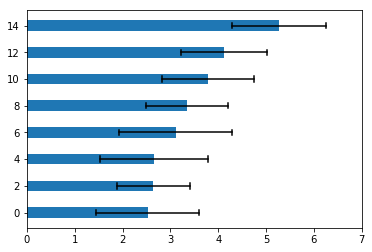

In [18]:
uni2gene = pd.read_csv("{0}/Data/Proteins.txt".format(base_dir), sep="\t").set_index("ID")["Gene_Name"].to_dict()
ORs = merged[(merged["Rank"] == 1)&(merged["p-value"] <= 0.05)].sort_values("Log2 Odds Ratio", ascending=True)["Log2 Odds Ratio"]
plt.barh(y=[2*x for x in range(len(ORs))], width=ORs)
y = 0
for uni, drug, OR, low, up, in merged[(merged["Rank"] == 1)&(merged["p-value"] <= 0.05)].sort_values("Log2 Odds Ratio", ascending=True)[["Human_Protein", "Compound_Name", "Log2 Odds Ratio", "Lower CI", "Upper CI"]].values:
    plt.plot([low, up], [y, y], color="k")
    plt.plot([low, low], [y-0.2, y+0.2], color="k")
    plt.plot([up, up], [y-0.2, y+0.2], color="k")
    y += 2
    print uni2gene[uni] + " : " + drug
plt.xlim(0, 7)

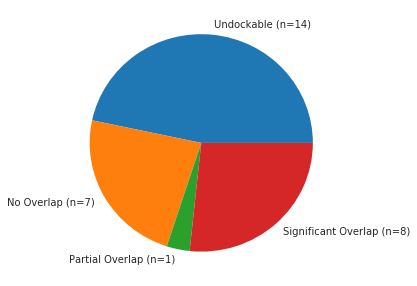

In [75]:
plt.figure(figsize=(5, 5))
merged["No Overlap"] = pd.isnull(merged["Log2 Odds Ratio"]) & (~pd.isnull(merged["P2_Ires"]))
a = len(merged[(merged["Rank"] == 1)&(pd.isnull(merged["p-value"]))&(~merged["No Overlap"])])
b = merged[merged["Rank"] == 1]["No Overlap"].sum()
c = (merged[(merged["Rank"] == 1)&(~merged["No Overlap"])]["p-value"] > 0.05).sum()
d = (merged[(merged["Rank"] == 1)&(~merged["No Overlap"])]["p-value"] <= 0.05).sum()
plt.pie([a, b, c, d], labels=["Undockable (n={0})".format(a), "No Overlap (n={0})".format(b), "Partial Overlap (n={0})".format(c), "Significant Overlap (n={0})".format(d)])
merged = merged.drop("No Overlap", axis=1)

In [80]:
merged[(merged["Rank"] == 1)&(merged["p-value"] <= 0.05)].sort_values("Log2 Odds Ratio", ascending=False)

,Human_Protein,Compound_Name,Rank,Score,Ires,P1,Source,P2_Ires,Jaccard,Ligand Recall,Log2 Odds Ratio,Lower CI,Upper CI,p-value
110,P27448,ZINC95559591,1,-7.280588,"60,61,62,63,70,85,134,135,136,138,139,182,195,...",COVID19orf9b,Docking,"60,61,62,63,64,65,70,81,134,135,136,137,138,13...",0.279070,0.800000,5.269461,3.666863,6.872058,3.179493e-08
70,P19784,Silmitasertib,1,-10.969420,"46,47,48,49,51,52,54,67,115,159,161,176",COVID19N,Docking,"47,48,49,50,51,121,123,124,127,159,161,176,179...",0.194444,0.583333,4.119633,2.641715,5.597550,2.270367e-06
200,Q92769,Apicidin,1,-7.705235,"28,99,100,150,151,205,206,271,272,302",COVID19nsp5,Docking,"24,26,27,28,30,32,82,85,86,89,90,92,93,94,96,9...",0.133333,0.600000,3.782109,2.193152,5.371065,4.517253e-05
80,P19784,TMCB,1,-7.318310,"46,47,48,49,52,54,67,115,116,119,159,161,176",COVID19N,Docking,"47,48,49,50,51,121,123,124,127,159,161,176,179...",0.157895,0.461538,3.343205,1.933497,4.752912,4.792419e-05
190,Q8N183,Metformin,1,-4.465364,"78,79,101,102,105,113,118",COVID19nsp7,Docking,"79,80,81,86,87,90,91,94,95,99,101,103,104,105,...",0.200000,0.571429,3.106915,1.161383,5.052448,4.310277e-03
210,Q92769,Valproic Acid,1,-4.996406,"100,150,151,205,206,272,302",COVID19nsp5,Docking,"24,26,27,28,30,32,82,85,86,89,90,92,93,94,96,9...",0.066667,0.428571,2.663464,0.805880,4.521049,9.175859e-03
60,P17612,H-89,1,-9.018489,"51,52,53,54,56,58,85,122,128,169,171,184,185,1...",COVID19nsp13,Docking,"48,52,53,54,56,79,82,83,130,131,134,135,136,13...",0.135593,0.500000,2.639824,1.390913,3.888736,2.537864e-04
90,P21964,Entacapone,1,-7.196985,"73,77,81,84,94,95,247,250,251,252",COVID19nsp7,Docking,"55,56,58,84,85,86,87,88,90,191,193,194,223,224...",0.125000,0.300000,2.524842,0.760267,4.289416,9.297844e-03


In [81]:
# Function to show verbose Odds Ratio Info for a
# single specified drug-target pair
def do(x):
    uni, iresA, iresB, rank = x
    mask1 = np.zeros(len(uni2seq[uni]))
    mask2 = np.zeros(len(uni2seq[uni]))
    
    if(pd.isnull(iresA)):
        iresA = set()
    else:
        iresA = set([int(x)-1 for x in iresA.split(",")])
    if(pd.isnull(iresB)):
        iresB = set()
    else:
        iresB = set([int(x)-1 for x in iresB.split(",")])
    
    mask1[sorted(iresA)] = 1
    mask2[sorted(iresB)] = 1
    
    coverage_mask = uni2coverage_mask[uni] == 1
    
    #print mask1[coverage_mask]
    #print type(mask1[coverage_mask])
    #print set(mask1[coverage_mask])
    #print set(mask2[coverage_mask])
    #1/0
    
    OR, up, low, p = my.odds_ratio(mask1[coverage_mask], mask2[coverage_mask], verbose=True, expose_label="Protein", case_label="Drug")
    OR, up, low = np.log2([OR, up, low])
    
    if(rank == 1 and sum(mask2) != 0):
        if(not uni in uni2piresmask.keys()):
            uni2piresmask[uni] = mask1[coverage_mask] == 1
            uni2liresmask[uni] = mask2[coverage_mask] == 1
        else:
            print "HERE"
            uni2piresmask[uni] = uni2piresmask[uni] | (mask1[coverage_mask] == 1)
            uni2liresmask[uni] = uni2liresmask[uni] | (mask2[coverage_mask] == 1)
    elif(rank == 1):
        print uni
    return OR, up, low, p
# FUNCTION END

In [90]:
prot = "P19784"
drug = "Silmitasertib "
ires1, ires2 = merged[(merged["Rank"] == 1)&(merged["Compound_Name"] == drug)&(merged["Human_Protein"] == prot)][["Ires", "P2_Ires"]].values[0]
do((prot, ires2, ires1, 1))

             Drug  Non-Drug
Protein       7.0      24.0
Non-Protein   5.0     298.0
HERE


(4.1196328469112471,
 5.8806802711683943,
 2.3585854226541008,
 4.5407334254843335e-06)

# Create PyMol Sessions to Visualize Enriched Drug / Protein Docked Sites

In [95]:
# Merge significant hits with original interaction table
# to add in protein description / function
interactions = pd.read_csv("{0}/COVID19_Interactome.txt".format(base_dir), sep="\t")

tmp = merged[(merged["p-value"] <= 0.05)&(merged["Rank"] == 1)].sort_values("Log2 Odds Ratio").copy()
tmp = tmp.join(interactions.set_index("Preys"), on=["Human_Protein"], how="inner")
tmp = tmp[["Compound_Name", "Human_Protein", "PreyGene", "P1", "Uniprot Protein Description", "Uniprot Function", "Log2 Odds Ratio", "Lower CI", "Upper CI", "p-value", "Ligand Recall"]].sort_values("Log2 Odds Ratio")
tmp.columns = ["Compound Name", "Human Protein", "UniProt ID", "Viral Interactor", "Protein Description", "Protein Function", "LogOdds", "CI_Low", "CI_Up", "P-value", "Ligand Recall"]
tmp.sort_values("LogOdds", ascending=False)

,Compound Name,Human Protein,UniProt ID,Viral Interactor,Protein Description,Protein Function,LogOdds,CI_Low,CI_Up,P-value,Ligand Recall
110,ZINC95559591,P27448,MARK3,COVID19orf9b,MAP/microtubule affinity-regulating kinase 3 (...,Serine/threonine-protein kinase (PubMed:23666...,5.269461,3.666863,6.872058,3.179493e-08,0.800000
70,Silmitasertib,P19784,CSNK2A2,COVID19N,Casein kinase II subunit alpha' (CK II alpha')...,Catalytic subunit of a constitutively active ...,4.119633,2.641715,5.597550,2.270367e-06,0.583333
200,Apicidin,Q92769,HDAC2,COVID19nsp5,Histone deacetylase 2 (HD2) (EC 3.5.1.98),Responsible for the deacetylation of lysine r...,3.782109,2.193152,5.371065,4.517253e-05,0.600000
80,TMCB,P19784,CSNK2A2,COVID19N,Casein kinase II subunit alpha' (CK II alpha')...,Catalytic subunit of a constitutively active ...,3.343205,1.933497,4.752912,4.792419e-05,0.461538
190,Metformin,Q8N183,NDUFAF2,COVID19nsp7,NADH dehydrogenase [ubiquinone] 1 alpha subcom...,Acts as a molecular chaperone for mitochondri...,3.106915,1.161383,5.052448,4.310277e-03,0.571429
210,Valproic Acid,Q92769,HDAC2,COVID19nsp5,Histone deacetylase 2 (HD2) (EC 3.5.1.98),Responsible for the deacetylation of lysine r...,2.663464,0.805880,4.521049,9.175859e-03,0.428571
60,H-89,P17612,PRKACA,COVID19nsp13,cAMP-dependent protein kinase catalytic subuni...,Phosphorylates a large number of substrates i...,2.639824,1.390913,3.888736,2.537864e-04,0.500000
90,Entacapone,P21964,COMT,COVID19nsp7,Catechol O-methyltransferase (EC 2.1.1.6),"Catalyzes the O-methylation, and thereby the ...",2.524842,0.760267,4.289416,9.297844e-03,0.300000


In [99]:
if(not os.path.exists("{0}/Data/PyMolSessions/Docked_Drugs".format(base_dir))):
    os.system("mkdir -p {0}/Data/PyMolSessions/Docked_Drugs".format(base_dir))

In [100]:
import __main__
__main__.pymol_argv = ['pymol','-cqk'] # Pymol: quiet and no GUI

import pymol
pymol.finish_launching()
from pymol import cmd as pymolCmd
pymolCmd.reinitialize()

# Iterate over significant hits
for drug, p1, p2 in tmp[["Compound Name", "Human Protein", "Viral Interactor"]].values:
    drug = drug.replace("-", "_").replace(" ", "_").split("(")[0]
    drug_f = glob.glob("{0}/Data/Docked_Ligands/{1}_{2}.pdb".format(base_dir, p1, drug))[0]
    
    try:
        uni_f = glob.glob("{0}/Data/Undocked_Structures/{1}*".format(base_dir, p1))[0]
    except IndexError:
        continue
    
    try:
        docked_f = glob.glob("{0}/Data/Docked_Structures/*{1}_{2}*".format(base_dir, p2, p1))[0]
    except:
        docked_f = None
    
    # Get Eclair Preds
    preds = pd.read_csv("{0}/Data/Eclair_Predictions/{1}_{2}.txt".format(base_dir, p2, p1), sep="\t")
    preds = preds.set_index(["Prot", "Pos"])["Pred"].to_dict()
    
    # Create Pymol Session
    pymolCmd.reinitialize()
    
    # Load Original Structure / Docked Structure
    pymolCmd.load(uni_f, p1)
    pymolCmd.load(drug_f, drug)
    if(docked_f):
        pymolCmd.load(docked_f, "{0}_Docked".format(p1))
        pymolCmd.align("{0}_Docked".format(p1), p1)
    else:
        print drug, p1, p2
        continue
    
    print "A", docked_f
    
    # Color By Prediction
    cmapA = matplotlib.cm.get_cmap('Greens')
    cmapB = matplotlib.cm.get_cmap('Blues')
    pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(float(0))[:3]).replace("#", "0x"), "{0}".format(p1))
    for k, pred in preds.iteritems():
        prot, resi = k
        if(np.isnan(pred)):
            pred = 0
        if(0 <= pred < 0.12):
            pred = 0
        elif(0.12 <= pred < 0.24):
            pred = 0.12
        elif(0.24 <= pred < 0.36):
            pred = 0.24
        elif(0.36 <= pred < 0.48):
            pred = 0.60
        else:
            pred = 0.90
        if(prot == 0):
            pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(float(pred))[:3]).replace("#", "0x"), "{0}_Docked and chain A and resi {2}".format(p1, p2, int(resi)))
        else:
            pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(float(pred))[:3]).replace("#", "0x"), "{0} and resi {1}".format(p1, int(resi)))
            if(docked_f):
                pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(float(pred))[:3]).replace("#", "0x"), "{0}_Docked and chain B and resi {2}".format(p1, p2, int(resi)))
    
    if(docked_f):
        pymolCmd.extract(p2 + "_Docked", "{0}_Docked and chain A".format(p1))
    
    # Save the Sessions
    pymolCmd.save("{0}/Data/PyMolSessions/Docked_Drugs/{1}_{2}.pse".format(base_dir, p1, drug))

A /home/sdw95/3D_SARS2/Data/Docked_Structures/COVID19nsp7_P21964_top_dock.pdb
A /home/sdw95/3D_SARS2/Data/Docked_Structures/COVID19nsp13_P17612_top_dock.pdb
A /home/sdw95/3D_SARS2/Data/Docked_Structures/COVID19nsp5_Q92769_top_dock.pdb
A /home/sdw95/3D_SARS2/Data/Docked_Structures/COVID19nsp7_Q8N183_top_dock.pdb
A /home/sdw95/3D_SARS2/Data/Docked_Structures/COVID19N_P19784_top_dock.pdb
A /home/sdw95/3D_SARS2/Data/Docked_Structures/COVID19nsp5_Q92769_top_dock.pdb
A /home/sdw95/3D_SARS2/Data/Docked_Structures/COVID19N_P19784_top_dock.pdb
A /home/sdw95/3D_SARS2/Data/Docked_Structures/COVID19orf9b_P27448_top_dock.pdb


In [20]:
import __main__
__main__.pymol_argv = ['pymol','-cqk'] # Pymol: quiet and no GUI

import pymol
pymol.finish_launching()
from pymol import cmd as pymolCmd

In [21]:
def polarpairs(sel1, sel2, cutoff=4.0, angle=63.0, name='', state=1, quiet=1):
    '''
ARGUMENTS

    sel1, sel2 = string: atom selections

    cutoff = float: distance cutoff

    angle = float: h-bond angle cutoff in degrees. If angle="default", take
    "h_bond_max_angle" setting. If angle=0, do not detect h-bonding.

    name = string: If given, also create a distance object for visual representation

SEE ALSO

    pymolCmd.find_pairs, pymolCmd.distance
    '''
    cutoff = float(cutoff)
    quiet = int(quiet)
    state = int(state)
    if angle == 'default':
        angle = pymolCmd.get('h_bond_max_angle', pymolCmd.get_object_list(sel1)[0])
    angle = float(angle)
    mode = 1 if angle > 0 else 0
    x = pymolCmd.find_pairs('(%s) and donors' % sel1, '(%s) and acceptors' % sel2,
            state, state,
            cutoff=cutoff, mode=mode, angle=angle) + \
        pymolCmd.find_pairs('(%s) and acceptors' % sel1, '(%s) and donors' % sel2,
            state, state,
            cutoff=cutoff, mode=mode, angle=angle)
    x = sorted(set(x))
    if not quiet:
        print('Settings: cutoff=%.1fangstrom angle=%.1fdegree' % (cutoff, angle))
        print('Found %d polar contacts' % (len(x)))
    if len(name) > 0:
        for p in x:
            pymolCmd.distance(name, '(%s`%s)' % p[0], '(%s`%s)' % p[1])
    return x
# FUNCTION END

pymolCmd.extend('polarpairs', polarpairs)

<function __main__.polarpairs>

In [27]:
tmp = my.call("grep P27448 ../Data/Interface_Summary.txt | grep Docking")[0].split("\t")
iresV = [int(x) for x in tmp[-4].split(",")]
iresH = [int(x) for x in tmp[-1].split(",")]
print iresV
print iresH
iresHD = [int(x) for x in my.call("grep P27448 ../Data/Drug_Docking_Ires_Summary.txt | grep ZINC95559591")[0].split("\t")[-1].split(",")]
print iresHD

[39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 58, 61, 62, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 76]
[60, 61, 62, 63, 64, 65, 70, 81, 134, 135, 136, 137, 138, 139, 141, 142, 143, 145, 146, 182, 185, 188, 201, 204, 210, 211, 213, 214, 249, 250, 251, 254, 255, 256, 260, 264, 267, 269, 270, 271]
[60, 61, 62, 63, 70, 85, 134, 135, 136, 138, 139, 182, 195, 196, 204]


In [28]:
pymolCmd.reinitialize()

# Load PPI
A = "COVID19orf9b"
B = "MARK3_PPI"
pymolCmd.load("../Data/Docked_Structures/COVID19orf9b_P27448_top_dock.pdb", A)
pymolCmd.extract(B, A + " and chain B")

# Load PDI
C = "MARK3_PDI"
D = "ZINC95559591"
pymolCmd.load("../Data/Undocked_Structures/P27448_2QNJ_A.pdb", C)
pymolCmd.load("../Data/Docked_Ligands/P27448_ZINC95559591.pdb", D, state=1)
pymolCmd.align(C, B)
pymolCmd.matrix_copy(C, D)
#pymolCmd.extract(C, D + " and resn UNL")

pymolCmd.extract("Junk", "element h and not " + D)
pymolCmd.delete("Junk")

# Initial Display Settings
pymolCmd.show("cartoon", "not " + D)
pymolCmd.show("sticks", D)
pymolCmd.hide("lines", "all")


# Color Chains
cmapA = matplotlib.cm.Blues
cmapB = matplotlib.cm.Greens

pymolCmd.save("../Figures/orf9b_MARK3_Drug_Figure.pse")

vires = "{0} and (resi {1})".format(A, " or resi ".join([str(x) for x in iresV]))
hires_PPI = "{0} and (resi {1})".format(B, " or resi ".join([str(x) for x in iresH]))
hires_PDI = "{0} and (resi {1})".format(C, " or resi ".join([str(x) for x in iresHD]))
sA = "{0} and (resi {1})".format(C, " or resi ".join([str(x) for x in iresH]))
sB = "{0} and (resi {1})".format(C, " or resi ".join([str(x) for x in iresHD]))

pymolCmd.select("orf9b_Ires", vires)
pymolCmd.select("MARK3_PPI_ires", hires_PPI)
pymolCmd.select("MARK3_PDI_ires", hires_PDI)
pymolCmd.select("sA", sA)
pymolCmd.select("sB", sB)
pymolCmd.select("sC", sA + " and " + sB)

pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.24)[:3]).replace("#", "0x"), A)
pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.24)[:3]).replace("#", "0x"), B + " or " + C)
pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.48)[:3]).replace("#", "0x"), "orf9b_Ires")
pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.48)[:3]).replace("#", "0x"), "MARK3_PPI_ires")
pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.48)[:3]).replace("#", "0x"), "MARK3_PDI_ires")


# Display lines for Ires
pymolCmd.show("sticks", "(orf9b_Ires or MARK3_PPI_ires or MARK3_PDI_ires) and (sidechain or name CA)")

# Create super surface
for name in [A, B, C]:
    pymolCmd.copy_to(name + "_Surface", name)
    pymolCmd.hide("everything", name + "_Surface")
    pymolCmd.show("surface", name + "_Surface")
#pymolCmd.set("transparency", 0.6)

# Color by element
pymolCmd.color("atomic", "({0} or {1} or {2} or {3}) and not element C".format(A, B, C, D))

# Hide Hydrogens
pymolCmd.hide("everything", "element h")

# Flag Polar Contacts
pairs1 = polarpairs(A, B, name="PPI_Polar_Pairs")
pairs2 = polarpairs(C, D, name="PDI_Polar_Pairs")
if(len(pairs1)):
    pymolCmd.hide("labels", "PPI_Polar_Pairs")
if(len(pairs2)):
    pymolCmd.hide("labels", "PDI_Polar_Pairs")
print len(pairs1)
print len(pairs2)

pymolCmd.save("../Figures/orf9b_MARK3_Drug_Figure.pse")

#non_ires_sele = "chain A and not (resi {0})".format(" or resi ".join([str(x) for x in iresA])) + " or " + "chain B and not (resi {0})".format(" or resi ".join([str(x) for x in iresB]))
#pymolCmd.select("Non-Ires", non_ires_sele) 

15
3


In [36]:
print len(set(iresH).difference(iresHD))
print len(set(iresH).intersection(iresHD))
print len(set(iresHD).difference(iresH))

28
12
3
